# Copyright Netherlands eScience Center <br>
** Function     : Lead/Lag regression of climatological fields on OMET with spatial patterns** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2018.08.29 ** <br>
** Last Update  : 2019.01.02 ** <br>
Description     : This notebook includes the result of the lag regression of climatological fields (e.g. SST, SLP, z500) on OMET. It aims to unveil the relation between the climatological fields and OMET and try to illustrate how the ocean drives the atmosphere through the change of OMET.
Besides, the contribution of stationary eddy and steady mean transport are studied here too.<br>
Return Values   : jpeg <br>

In [1]:
%matplotlib inline

import sys
sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import numpy as np
import scipy
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import os
import meta.statistics
import meta.visualizer

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import iris
import iris.plot as iplt
import cartopy
import cartopy.crs as ccrs

Initialization - Start with location of input and extraction of variables
Time span of each product:
- **ERA-Interim** 1979 - 2016
- **MERRA2**      1980 - 2016
- **JRA55**       1979 - 2015
- **ORAS4**       1958 - 2014
- **GLORYS2V3**   1993 - 2014
- **SODA3**       1980 - 2015

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            }

In [3]:
if __name__=="__main__":
    # sample
    ################################   Input zone  ######################################
    # specify data path
    datapath = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met'
    datapath_ERAI_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/regression'
    datapath_ORAS4_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ORAS4/regression'
    datapath_ORAS4_mask = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ORAS4'
    output_path = '/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Compensation/MET_mechanism/OMET/spatial'
    #####################################################################################
    print ('*********************** extract variables *************************')
    dataset_ERAI_fields_SIC_SST_SLP = Dataset(os.path.join(datapath_ERAI_fields,
                                              'surface_ERAI_monthly_regress_1979_2016.nc'))
    dataset_ERAI_fields_SFlux = Dataset(os.path.join(datapath_ERAI_fields,
                                        'surface_ERAI_monthly_regress_1979_2016_extra.nc'))
    dataset_ERAI_500hPa = Dataset(os.path.join(datapath_ERAI_fields,
                                  'pressure_500hPa_ERAI_monthly_regress_1979_2016.nc'))
    dataset_ORAS4_OMET = Dataset(os.path.join(datapath,
                                 'oras_model_monthly_1958_2017_omet.nc'))
    dataset_ERAI_fields_flux = Dataset(os.path.join(datapath_ERAI_fields,
                                       'surface_erai_monthly_regress_1979_2017_radiation.nc'))
    dataset_ORAS4_fields_ssh = Dataset(os.path.join(datapath_ORAS4_fields,
                                       'oras_monthly_regress_1958_2017_ssh.nc'))
    dataset_ORAS4_mask = Dataset(os.path.join(datapath_ORAS4_mask, 'mesh_mask.nc'))
    dataset_ERAI_fields_z500var = Dataset(os.path.join(datapath_ERAI_fields,
                                          'pressure_erai_subdaily_regress_1979_2017_z500var.nc')) 
    # extract time series from 1979 to 2016
    # from 20N - 90N
    # 4D fields [year, month, lat, lon]
    # geopotential height at 500hPa (m)
    z_500hPa_ERAI = dataset_ERAI_500hPa.variables['z'][:] / constant['g']
    z500var_ERAI = dataset_ERAI_fields_z500var.variables['z500var'][:-1,:,:,:]
    # flux
    rad_short_toa_ERAI = dataset_ERAI_fields_flux.variables['tsr'][:]
    rad_long_toa_ERAI = dataset_ERAI_fields_flux.variables['ttr'][:]
    rad_short_surf_ERAI = dataset_ERAI_fields_flux.variables['ssr'][:]
    rad_long_surf_ERAI = dataset_ERAI_fields_flux.variables['str'][:]
    SFlux_sensible_ERAI = dataset_ERAI_fields_flux.variables['sshf'][:]
    SFlux_latent_ERAI = dataset_ERAI_fields_flux.variables['slhf'][:]
    # sea surface height from ORAS4
    SSH_ORAS4 = dataset_ORAS4_fields_ssh.variables['ssh'][21:-1,:,180:,:]
    # calculate total net energy flux at TOA/surface
    net_flux_surf_ERAI = rad_short_surf_ERAI + rad_long_surf_ERAI + SFlux_sensible_ERAI + SFlux_latent_ERAI
    net_flux_toa_ERAI = rad_short_toa_ERAI + rad_long_toa_ERAI
    # 3D fields [time, lat, lon]
    SLP_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['msl'][:]
    SST_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['sst'][:]
    SST_ERAI_mask = np.ma.getmaskarray(SST_ERAI[0,:,:])
    SIC_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['ci'][:]
    SIC_ERAI_mask = np.ma.getmaskarray(SIC_ERAI[0,:,:])
    # instantaneous turbulent flux
    #SFlux_sensible_ERAI = dataset_ERAI_fields_SFlux.variables['ishf'][:] # W/m2
    #SFlux_latent_ERAI = dataset_ERAI_fields_SFlux.variables['ie'][:] * constant['Lv'] # W/m2
    # 3D fields [year, month, lat]
    OMET_int_ORAS4 = dataset_ORAS4_OMET.variables['E_int'][21:-1,:,180:]/1000 # from Tera Watt to Peta Watt # start from 1979
    OMET_atl_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_int'][21:-1,:,180:]/1000
    OMET_atl_100_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_100_int'][21:-1,:,180:]/1000
    OMET_atl_300_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_300_int'][21:-1,:,180:]/1000
    OMET_atl_700_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_700_int'][21:-1,:,180:]/1000
    OMET_atl_2000_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_2000_int'][21:-1,:,180:]/1000
    
    OMET_pac_int_ORAS4 = dataset_ORAS4_OMET.variables['E_pac_int'][21:-1,:,180:]/1000  
    # other dimensions
    year_ORAS4 = dataset_ORAS4_OMET.variables['year'][21:-1]    # from 1979 to 2016
    latitude_OMET_ORAS4 = dataset_ORAS4_OMET.variables['latitude_aux'][180:]
    gphiv_OMET_ORAS4 = dataset_ORAS4_OMET.variables['gphiv'][180:,:]
    glamv_OMET_ORAS4 = dataset_ORAS4_OMET.variables['glamv'][180:,:]
    latitude_fields_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['latitude'][:]
    longitude_fields_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['longitude'][:]
    mask_ORAS4 = dataset_ORAS4_mask.variables['vmask'][0,0,180:,:]
    # area weighted surface flux
    net_flux_surf_ERAI_area = np.zeros(net_flux_surf_ERAI.shape, dtype=float) # unit W
    net_flux_toa_ERAI_area = np.zeros(net_flux_toa_ERAI.shape, dtype=float)
    #size of the grid box
    dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_fields_ERAI /
                                            360) / len(longitude_fields_ERAI) 
    dy = np.pi * constant['R'] / len(latitude_fields_ERAI)
    for i in np.arange(len(latitude_fields_ERAI)):
        # change the unit to terawatt
        net_flux_surf_ERAI_area[:,:,i,:] = net_flux_surf_ERAI[:,:,i,:]* dx[i] * dy / 1E+12
        net_flux_toa_ERAI_area[:,:,i,:] = net_flux_toa_ERAI[:,:,i,:]* dx[i] * dy / 1E+12
        #net_flux_toa_ERAI_area[:,:,i,:] = net_flux_toa_ERAI[:,:,i,:]

*********************** extract variables *************************


In [6]:
print (latitude_OMET_ORAS4[53])

60.018433


*******************  quantify the autocorrelation  *********************
===================  OMET + atl + 60N + full year  =====================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!


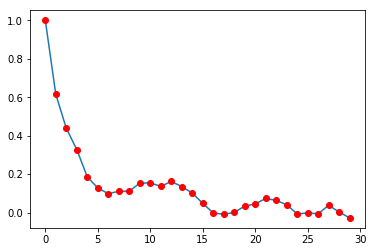

[1.         0.61532651 0.43856333 0.32766237 0.18601411 0.12820976
 0.09874498 0.11062131 0.11152124 0.15289144]


In [4]:
    print ('*******************  quantify the autocorrelation  *********************')
    print ('===================  OMET + atl + 60N + full year  =====================')
    # account for the autocorrelation
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_atl_int_ORAS4[:,:,53])
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    auto_corr_OMET = meta.statistics.operator.autoCorr(stat_OMET_ORAS4._detrend)
    fig = plt.figure()
    plt.plot(auto_corr_OMET[:30])
    plt.plot(auto_corr_OMET[:30], 'ro')
    plt.show()
    fig.savefig(os.path.join(output_path,'autoCorr_OMET_fullyear.png'), dpi=300)
    print(auto_corr_OMET[:10])

*******************  postprocess with statistical tool  *********************
***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
======================   OMET + atl + 60N & SST   =====================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
This a regression with lead/lag analysis.
Positive lag means 2nd input leads 1st, vice versa.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


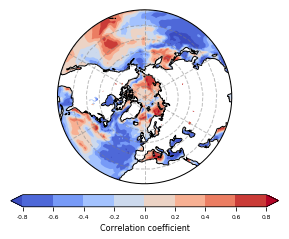

In [36]:
    print ('*******************  postprocess with statistical tool  *********************')
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('======================   OMET + atl + 60N & SST   =====================')
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_atl_int_ORAS4[:,:,53])
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_OMET_ORAS4.lowpass(window=120, obj='detrend')
    stat_SST_ERAI = meta.statistics.operator(SST_ERAI[:,:95,:])
    stat_SST_ERAI.anomaly(Dim_month=False)
    stat_SST_ERAI.detrend()
    stat_SST_ERAI.lowpass(window=120, obj='detrend')
    lag = 0
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_SST_ERAI._lowpass, lag)
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    ticks = [i for i in np.linspace(-3.0,3.0,11)]
    label = 'Correlation coefficient'
    meta.visualizer.plots.geograph(latitude_fields_ERAI[:95], longitude_fields_ERAI[:],
                                   np.ma.masked_where(SST_ERAI_mask[:95,:],r), p,
                                   label, ticks, os.path.join(output_path, 'omet_sst',
                                   'spatial_ORAS4_atl_OMET_60N_lag_{}_ERAI_SST_decadal.png'.format(lag)))
    

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
======================   OMET + atl + 60N & SLP   =====================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
This a regression with lead/lag analysis.
Positive lag means 2nd input leads 1st, vice versa.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


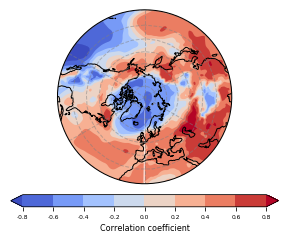

In [51]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('======================   OMET + atl + 60N & SLP   =====================')
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_atl_int_ORAS4[:,:,53])
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_OMET_ORAS4.lowpass(window=120, obj='detrend')
    stat_SLP_ERAI = meta.statistics.operator(SLP_ERAI[:,:95,:])
    stat_SLP_ERAI.anomaly(Dim_month=False)
    stat_SLP_ERAI.detrend()
    stat_SLP_ERAI.lowpass(window=120, obj='detrend')
    lag = -24
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_SLP_ERAI._lowpass, lag)
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'Correlation coefficient'
    meta.visualizer.plots.geograph(latitude_fields_ERAI[:95], longitude_fields_ERAI[:], r, p,
                                   label, ticks, os.path.join(output_path, 'omet_slp',
                                   'spatial_ORAS4_atl_OMET_60N_lag_{}_ERAI_SLP_decadal.png'.format(lag)))  

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
======================   OMET + atl + 60N & z500   =====================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
This a regression with lead/lag analysis.
Positive lag means 2nd input leads 1st, vice versa.
One time series is regressed on a 2D field.
This a regression with lead/lag analysis.
Positive lag means 2nd input leads 1st, vice versa.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


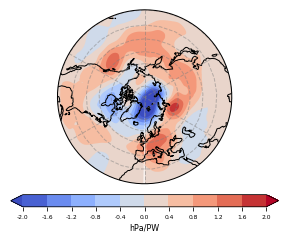

[[-301.59323043 -301.88935721 -302.42807208 -302.65858474 -303.04033601
  -303.32370607 -303.51314256 -303.80793812 -303.85660083 -304.02236148]
 [-300.65643531 -300.86155416 -300.90185991 -300.93424918 -300.87930291
  -300.72537986 -300.69460117 -300.49863745 -300.42624199 -300.27333631]
 [-299.38932539 -299.24991134 -299.10852593 -298.71802142 -298.11844959
  -297.80098888 -297.276219   -296.78610974 -296.20986936 -295.68025726]
 [-297.42179426 -296.87508283 -296.24392091 -295.51822803 -294.68739202
  -293.84909354 -292.97850123 -292.13582057 -291.09106428 -289.98612159]
 [-294.22311101 -293.44810182 -292.4145608  -291.27406326 -290.22514966
  -289.00199081 -287.61155704 -286.35058582 -285.0027265  -283.58422209]
 [-290.00807744 -288.79307457 -287.501094   -286.21151396 -284.85636027
  -283.03229863 -281.52875056 -279.89868652 -278.09664654 -276.33776367]
 [-284.10436383 -282.67271458 -281.1307358  -279.42429891 -277.69265638
  -275.94421579 -274.03470886 -271.91320133 -270.12185606 

In [20]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('======================   OMET + atl + 60N & z500   =====================')
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_atl_int_ORAS4[:,:,53])
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_OMET_ORAS4.lowpass(window=12, obj='detrend')
    stat_z500_ERAI = meta.statistics.operator(z_500hPa_ERAI[:,:,:95,:])
    stat_z500_ERAI.anomaly()
    stat_z500_ERAI.detrend()
    stat_z500_ERAI.lowpass(window=12, obj='detrend')
    lag = 24
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_z500_ERAI._lowpass, lag)
    # regression for t-test value based on real degree of freedom
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                          stat_z500_ERAI._detrend, lag)
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    label = 'hPa/PW'
    #ticks = [i for i in np.linspace(-10.0,10.0,11)]
    ticks = [i for i in np.linspace(-2.0,2.0,11)]
    meta.visualizer.plots.geograph(latitude_fields_ERAI[:95], longitude_fields_ERAI[:], k/100, p_real,
                                   label, ticks, os.path.join(output_path, 'spatial', 'omet_z500',
                                   'spatial_ORAS4_atl_OMET_60N_lag_{}_ERAI_z500_annual.png'.format(lag)))
    print(k[10:20,30:40])

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
======================   OMET + atl + 60N & SIC   =====================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
This a regression with lead/lag analysis.
Positive lag means 2nd input leads 1st, vice versa.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


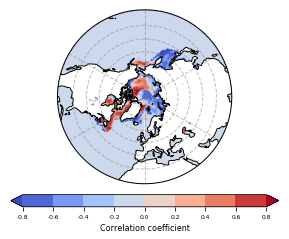

In [28]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('======================   OMET + atl + 60N & SIC   =====================')
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_atl_int_ORAS4[:,:,53])
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_OMET_ORAS4.lowpass(window=120, obj='detrend')
    stat_SIC_ERAI = meta.statistics.operator(SIC_ERAI[:,:95,:])
    stat_SIC_ERAI.anomaly(Dim_month=False)
    stat_SIC_ERAI.detrend()
    stat_SIC_ERAI.lowpass(window=120, obj='detrend')
    lag = -24
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_SIC_ERAI._lowpass, lag)
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'Correlation coefficient'
    meta.visualizer.plots.geograph(latitude_fields_ERAI[:95], longitude_fields_ERAI[:],
                                   np.ma.masked_where(SIC_ERAI_mask[:95,:],r), p,
                                   label, ticks, os.path.join(output_path, 'omet_sic',
                                   'spatial_ORAS4_atl_OMET_60N_lag_{}_ERAI_SIC_decadal.png'.format(lag)))  

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
===================   OMET + atl + 60N & total SFlux +=================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
This a regression with lead/lag analysis.
Positive lag means 2nd input leads 1st, vice versa.
One time series is regressed on a 2D field.
This a regression with lead/lag analysis.
Positive lag means 2nd input leads 1st, vice versa.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


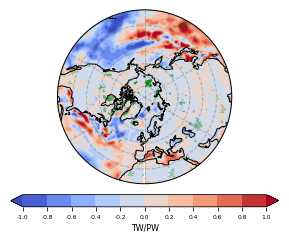

In [11]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('===================   OMET + atl + 60N & total SFlux +=================')
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_atl_int_ORAS4[:,:,53])
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_OMET_ORAS4.lowpass(window=60, obj='detrend')
    stat_SFlux_ERAI = meta.statistics.operator(net_flux_surf_ERAI_area[:-1,:,:95,:])
    stat_SFlux_ERAI.anomaly()
    stat_SFlux_ERAI.detrend()
    stat_SFlux_ERAI.lowpass(window=60, obj='detrend')
    lag = -24
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_SFlux_ERAI._lowpass, lag)
    # regression for t-test value based on real degree of freedom
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                          stat_SFlux_ERAI._detrend, lag)
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    ticks = [i for i in np.linspace(-1.0,1.0,11)]
    #label = 'Correlation coefficient'
    label = 'TW/PW'
    meta.visualizer.plots.geograph(latitude_fields_ERAI[:95], longitude_fields_ERAI[:], k, p_real,
                                   label, ticks, os.path.join(output_path, 'omet_SFlux',
                                   'spatial_ORAS4_atl_OMET_60N_lag_{}_ERAI_SFlux_interannual_area.png'.format(lag)),
                                   ttest=True)  

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
===================   OMET + atl + 60N & total net TOAFlux +=================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
This a regression with lead/lag analysis.
Positive lag means 2nd input leads 1st, vice versa.
One time series is regressed on a 2D field.
This a regression with lead/lag analysis.
Positive lag means 2nd input leads 1st, vice versa.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


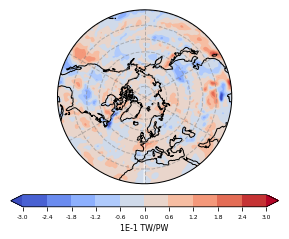

In [31]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('===================   OMET + atl + 60N & total net TOAFlux +=================')
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_atl_int_ORAS4[:,:,53])
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_OMET_ORAS4.lowpass(window=12, obj='detrend')
    stat_TOAFlux_ERAI = meta.statistics.operator(net_flux_toa_ERAI_area[:-1,:,:95,:])
    stat_TOAFlux_ERAI.anomaly()
    stat_TOAFlux_ERAI.detrend()
    stat_TOAFlux_ERAI.lowpass(window=12, obj='detrend')
    lag = -1
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_TOAFlux_ERAI._lowpass, lag)
    # regression for t-test value based on real degree of freedom
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                          stat_TOAFlux_ERAI._detrend, lag)
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    ticks = [i for i in np.linspace(-3.0,3.0,11)]
    label = '1E-1 TW/PW'
    meta.visualizer.plots.geograph(latitude_fields_ERAI[:95], longitude_fields_ERAI[:], k*10, p_real,
                                   label, ticks, os.path.join(output_path, 'omet_TOAFlux',
                                   'spatial_ORAS4_atl_OMET_60N_lag_{}_ERAI_TOAFlux_annual_area.png'.format(lag)))
    

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
==================+         OMET + atl + 60N & ssh      +=================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.


/home/ESLT0068/.pyenv/versions/anaconda3-5.3.0/lib/python3.7/site-packages/numpy/ma/core.py:3324: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  _data[indx] = dval


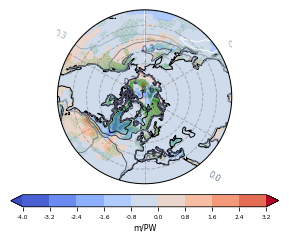

In [4]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('==================+         OMET + atl + 60N & ssh      +=================')
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_atl_int_ORAS4[:,:,53])
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_OMET_ORAS4.lowpass(window=120, obj='detrend')
    stat_SSH_ORAS4 = meta.statistics.operator(SSH_ORAS4)
    stat_SSH_ORAS4.anomaly()
    stat_SSH_ORAS4.detrend()
    stat_SSH_ORAS4.lowpass(window=120, obj='detrend')
    lag = 0
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                           stat_SSH_ORAS4._lowpass, lag)
    # regression for t-test value based on real degree of freedom
    _, _, p_real = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._detrend,
                                                           stat_SSH_ORAS4._detrend, lag)
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    ticks = [i for i in np.linspace(-4.0,4.0,11)]
    label = 'm/PW'

    # plot on curvelinear grid
    lat_iris = iris.coords.AuxCoord(gphiv_OMET_ORAS4, standard_name='latitude', long_name='latitude',
                                    var_name='lat', units='degrees')
    lon_iris = iris.coords.AuxCoord(glamv_OMET_ORAS4, standard_name='longitude', long_name='longitude',
                                    var_name='lon', units='degrees')
    # assembly the cube for the regression
    cube_iris = iris.cube.Cube(mask_ORAS4 * k,
                               long_name='curvilinear field', var_name='field', units='1',
                               aux_coords_and_dims=[(lat_iris, (0,1)), (lon_iris, (0,1))])
    coord_sys = iris.coord_systems.GeogCS(iris.fileformats.pp.EARTH_RADIUS)
    cube_iris.coord('latitude').coord_system = coord_sys
    cube_iris.coord('longitude').coord_system = coord_sys
    # assembly the cube for the mean ssh
    jj, ii = gphiv_OMET_ORAS4.shape
    ssh_series = SSH_ORAS4.reshape(len(year_ORAS4)*12, jj, ii)
    ssh_series_mean = np.mean(ssh_series, 0)
    cube_iris_ssh = iris.cube.Cube(mask_ORAS4 * ssh_series_mean,
                                   long_name='mean ssh', var_name='field', units='1',
                                   aux_coords_and_dims=[(lat_iris, (0,1)), (lon_iris, (0,1))])
    cube_iris_ssh.coord('latitude').coord_system = coord_sys
    cube_iris_ssh.coord('longitude').coord_system = coord_sys
    nx = 720
    ny = 140
    # regrid the cube
    cube_regrid, extent = iris.analysis.cartography.project(cube_iris, ccrs.PlateCarree(), nx, ny)
    cube_ssh_regrid, extent = iris.analysis.cartography.project(cube_iris_ssh,
                                                                     ccrs.PlateCarree(), nx, ny)
    # make plots
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180,180,20,90],ccrs.PlateCarree())
    ax.set_aspect('1')
    ax.coastlines()
    gl = ax.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    cs = iplt.contourf(cube_regrid, cmap='coolwarm', vmin=ticks[0], vmax=ticks[-1],extend='both') #pcolormesh
    cbar = fig.colorbar(cs,extend='both', orientation='horizontal',
                        shrink =0.8, pad=0.05, format="%1.1f") #
    cbar.set_label(label,size = 8)
    cbar.set_ticks(ticks)
    cbar.ax.tick_params(labelsize = 6)
    contour = iplt.contour(cube_ssh_regrid, linewidths = 0.8, cmap='bone')
    plt.clabel(contour, inline=True, inline_spacing = 8, fontsize = 8, fmt = '%1.1f')
    ii, jj = np.where(p_real<=0.05)
    ax.scatter(glamv_OMET_ORAS4[ii,jj], gphiv_OMET_ORAS4[ii,jj], transform=ccrs.Geodetic(),
               s=0.06, c='g',alpha=0.2)
    iplt.show()
    fig.savefig(os.path.join(output_path, 'omet_ssh',
                'spatial_ORAS4_atl_OMET_60N_lag_0_ERAI_ssh_decadal_meanSSH.png'), dpi=300)
    plt.close(fig)    

***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********
===================   OMET + atl + 60N & z500 variance  ==================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
This a regression with lead/lag analysis.
Positive lag means 2nd input leads 1st, vice versa.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


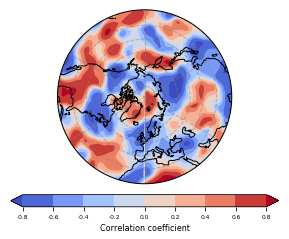

In [10]:
    print ('***********!@#$%^&*     Lead/ Lag regression of ORAS4   !@#$%^&***********')
    print ('===================   OMET + atl + 60N & z500 variance  ==================')
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_atl_int_ORAS4[:,:,53])
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_OMET_ORAS4.lowpass(window=120, obj='detrend')
    stat_z500var_ERAI = meta.statistics.operator(z500var_ERAI[:,:,:95,:])
    stat_z500var_ERAI.anomaly()
    stat_z500var_ERAI.detrend()
    stat_z500var_ERAI.lowpass(window=120, obj='detrend')
    lag = 30
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_z500var_ERAI._lowpass, lag)
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'Correlation coefficient'
    meta.visualizer.plots.geograph(latitude_fields_ERAI[:95], longitude_fields_ERAI[:], r, p,
                                   label, ticks, os.path.join(output_path, 'omet_z500var',
                                   'spatial_ORAS4_atl_OMET_60N_lag_{}_ERAI_z500_decadal.png'.format(lag))) 